In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta
from optim import *

In [3]:
cutoff_date = datetime(2023, 4, 30).date()
cutoff_date

datetime.date(2023, 4, 30)

In [4]:
pd.read_excel("portfolioTickers.xlsx")

,highCorrelationPortfolio,mixedCorrelationPortfolio,lowCorrelationPortfolio
0,AEE,PNW,ABT
1,AEP,TKO,AIG
2,CMS,AEP,AKAM
3,D,DUK,AXON
4,DTE,SO,CAG
5,DUK,CNC,CTRA
6,ED,DVA,DECK
7,ES,ED,DLTR
8,EVRG,WEC,MNST
9,LNT,AEE,MOH


Downloading historical prices

In [5]:
tickers = list(pd.read_excel("portfolioTickers.xlsx")["lowCorrelationPortfolio"])
prices = yf.download(tickers = tickers, start = "2015-04-30", end = "2025-04-30", progress = False)["Close"].dropna()
prices

YF.download() has changed argument auto_adjust default to True


Ticker,ABT,AIG,AKAM,AXON,CAG,CTRA,DECK,DLTR,MNST,MOH
Date,,,,,,,,,,
2015-04-30,38.385220,44.036976,73.779999,30.190001,20.326054,25.187592,12.333333,76.410004,22.851667,59.230000
2015-05-01,38.608471,45.171329,74.660004,32.369999,20.556589,25.269516,12.531667,77.730003,23.521667,59.549999
2015-05-04,38.864819,45.531212,75.099998,33.700001,20.871464,25.567417,12.335000,77.309998,23.641666,59.799999
2015-05-05,38.740780,45.374725,75.360001,34.599998,20.809608,25.306606,12.271667,76.339996,23.438334,58.250000
2015-05-06,38.484447,45.492077,75.040001,34.410000,20.916441,25.425837,12.178333,77.150002,23.413334,58.340000
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,129.839996,81.650002,75.870003,576.900024,24.858976,25.360001,106.660004,83.430000,59.090000,332.000000
2025-04-24,129.380005,82.449997,79.199997,590.669983,24.563272,25.459999,110.650002,81.230003,58.590000,313.809998
2025-04-25,128.850006,81.220001,79.790001,603.780029,24.100000,25.370001,109.190002,80.570000,58.669998,314.510010


In [6]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [7]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,ABT,AIG,AKAM,AXON,CAG,CTRA,DECK,DLTR,MNST,MOH
Date,,,,,,,,,,
2015-05-01,0.005816,0.025759,0.011927,0.072209,0.011342,0.003253,0.016081,0.017275,0.029320,0.005403
2015-05-04,0.006640,0.007967,0.005893,0.041087,0.015317,0.011789,-0.015694,-0.005403,0.005102,0.004198
2015-05-05,-0.003192,-0.003437,0.003462,0.026706,-0.002964,-0.010201,-0.005134,-0.012547,-0.008601,-0.025920
2015-05-06,-0.006617,0.002586,-0.004246,-0.005491,0.005134,0.004711,-0.007606,0.010610,-0.001067,0.001545
2015-05-07,-0.000860,0.014102,0.002665,-0.053182,0.004301,0.003810,0.009580,0.011147,0.021427,-0.001886
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,-0.011284,0.005238,-0.003583,-0.002311,0.007210,0.009427,0.006514,0.016359,0.011871,0.029469
2023-04-25,-0.003895,-0.016789,-0.014631,-0.016258,0.011135,-0.021401,-0.027723,-0.007168,0.009497,-0.015441
2023-04-26,-0.011094,-0.002748,-0.009689,-0.021372,-0.008390,-0.018290,0.004787,0.005710,0.000922,-0.013284


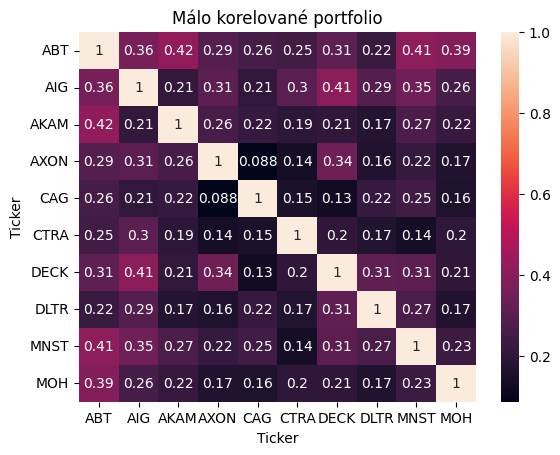

In [8]:
plt.Figure(figsize = (10, 10))
sns.heatmap(returns_train.corr(), annot = True)
plt.title("Málo korelované portfolio")
plt.show()

In [9]:
weightsMVOTangent = MVOTangentPortfolio(prices = prices)
weightsPlot(weightsMVOTangent, title = "MVO tangentní portfolio")

Expected annual return: 23.1%
Annual volatility: 25.2%
Sharpe Ratio: 0.92
(np.float64(0.23109359433706037), np.float64(0.2517109225549344), np.float64(0.9180912452721458))


In [10]:
weightsMVOTarget = MVOTargetReturn(prices = prices, target_return = 0.1)
weightsPlot(weightsMVOTarget, title = "MVO optimální portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 10.0%
Annual volatility: 17.3%
Sharpe Ratio: 0.58
(np.float64(0.10000000000000002), np.float64(0.1729799187557822), np.float64(0.5781017861453778))


In [11]:
weightsLWCorrelationTangent = MVOTangentPortfolio(prices = prices, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTangent, title = "Robustní MVO tangentní portfolio")

Expected annual return: 23.0%
Annual volatility: 25.0%
Sharpe Ratio: 0.92
(np.float64(0.22966508384569242), np.float64(0.2495649268609806), np.float64(0.920261860247801))


In [12]:
weightsLWCorrelationTarget = MVOTargetReturn(prices = prices, target_return = 0.1, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTarget, title = "Robustní MVO portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 10.0%
Annual volatility: 17.3%
Sharpe Ratio: 0.58
(np.float64(0.10000000000000003), np.float64(0.17291366759570156), np.float64(0.578323283465453))


In [13]:
weightsCustomDeltaTangent = RobustLedoitWolfCustomDeltaMaxSharpe(prices = prices, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTangent, title = "Robustní tangentní portfolio s deltou 0.5")

Expected annual return: 23.7%
Annual volatility: 21.9%
Sharpe Ratio: 1.09
(np.float64(0.23744898660268127), np.float64(0.21874865462269039), np.float64(1.085487757683567))


In [14]:
weightsCustomDeltaTarget = RobustLedoitWolfCustomDeltaTargetReturn(prices = prices, target_return = 0.1, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTarget, title = "Robustní portfolio s deltou 0.5 a cílovým výnosem 10% p.a.")

Expected annual return: 10.0%
Annual volatility: 15.0%
Sharpe Ratio: 0.67
(np.float64(0.09999999999999998), np.float64(0.14980757623849644), np.float64(0.6675229818870985))


In [15]:
weightsMinCVaR = CVaROptimizationMinCVAR(prices= prices, alpha = 0.05)
weightsPlot(weightsMinCVaR, title = "CVaR optimální portfolio")

Expected annual return: 7.1%
Conditional Value at Risk: 2.53%
(np.float64(0.07077308583618437), np.float64(0.025252155353346913))


In [16]:
anr = pd.DataFrame()

for ticker in tickers:
    rec = pd.read_excel(r"C:\Users\miros\Desktop\masters\BL_Input\AnalystRecommendation.xlsx", sheet_name = ticker)
    rec["Ticker"] = ticker
    anr = pd.concat([anr, rec])

anr["Upside"] = anr["Target Price"] / anr["Last Price"] - 1
anr

,Dates,Target Price,Last Price,Buy %,Hold %,Sell %,Price Spread,Ticker,Upside
0,2023-04-25,123.590912,109.97,0.740741,0.222222,0.037037,13.620912,ABT,0.123860
1,2023-05-25,123.590912,102.14,0.750000,0.214286,0.035714,21.450912,ABT,0.210015
2,2023-06-25,122.636360,108.05,0.730769,0.230769,0.038462,14.586360,ABT,0.134996
3,2023-07-25,124.105263,112.93,0.730769,0.269231,0.000000,11.175263,ABT,0.098957
4,2023-08-25,124.105263,104.21,0.730769,0.269231,0.000000,19.895263,ABT,0.190915
...,...,...,...,...,...,...,...,...,...
20,2024-12-25,361.333344,295.19,0.312500,0.625000,0.062500,66.143344,MOH,0.224070
21,2025-01-25,358.571442,304.33,0.312500,0.625000,0.062500,54.241442,MOH,0.178232
22,2025-02-25,331.333344,305.97,0.312500,0.625000,0.062500,25.363344,MOH,0.082895
23,2025-03-25,330.933319,310.53,0.375000,0.500000,0.125000,20.403319,MOH,0.065705


In [17]:
views = anr.loc[anr["Dates"] == "2023-04-25"][["Ticker", "Upside"]].set_index("Ticker")
views = views["Upside"].to_dict()
views

{'ABT': 0.12386025157074099,
 'AKAM': 0.14159080627295473,
 'CAG': 0.10401529633192474,
 'DECK': 0.04229069422896625,
 'MNST': 0.003592736913233807,
 'MOH': 0.25523668003437416}

In [18]:
weightsBLTangent = blackLittermanAbsoluteViewsMaxSharpe(prices = prices, views = views)
weightsPlot(weightsBLTangent, title = "Black-Litterman tangentní portfolio")

Expected annual return: 13.8%
Annual volatility: 19.2%
Sharpe Ratio: 0.72
(np.float64(0.13791543283188562), np.float64(0.19248917647684216), np.float64(0.7164840920210277))


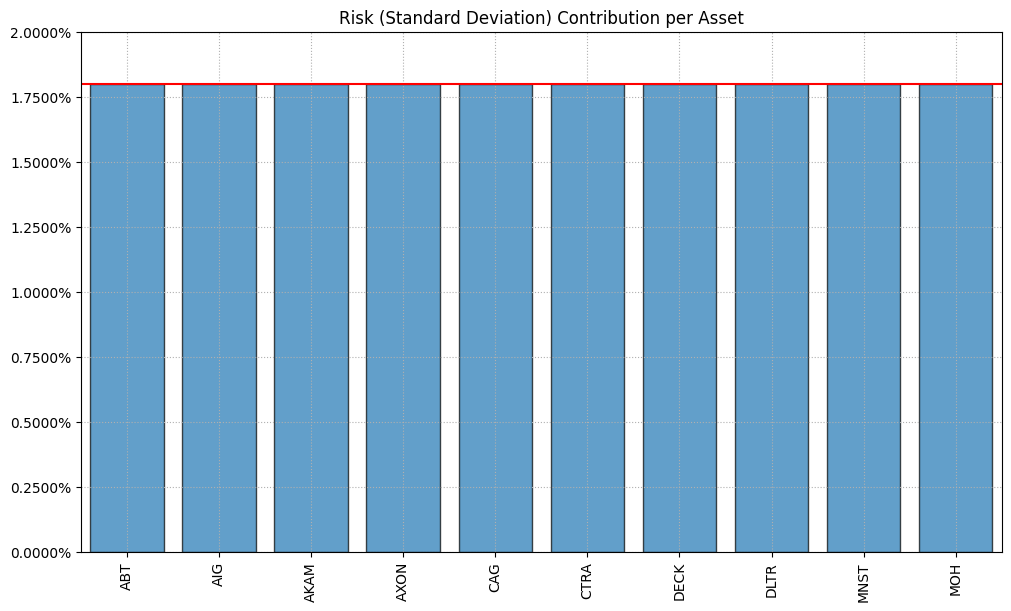

In [19]:
weightsRP_std, rpPlot = riskParityERC(prices = prices)
weightsPlot(weightsRP_std, title = "Rizikově paritní portfolio (směrodatná odchylka)")

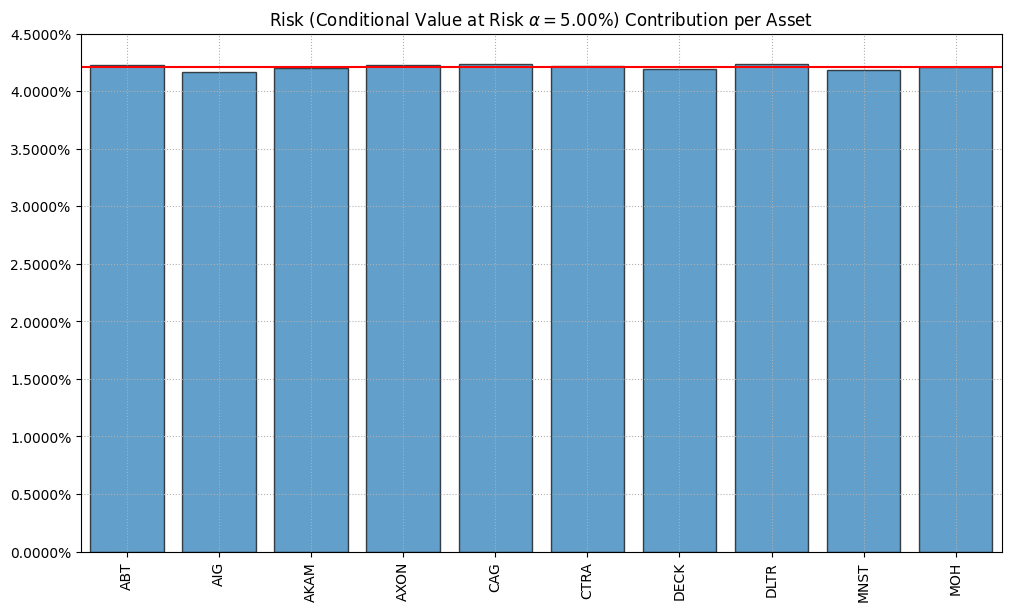

In [20]:
weightsRP_CVaR, rpPlot = riskParityERC(prices = prices, risk_measure = "CVaR")
weightsPlot(weightsRP_CVaR, title = "Rizikově paritní portfolio (CVaR)")

Hierarchical risk parity

In [21]:
in_sample = {
    'MVO Tangent': (weightsRebalancing(weightsMVOTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Target 10%': (weightsRebalancing(weightsMVOTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'LedoitWolf Tangent': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'LedoitWolf Target 10%': (weightsRebalancing(weightsLWCorrelationTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Tangent (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Target 10% (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'Black-Litterman Tangent': (weightsRebalancing(weightsBLTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns)

In [22]:
px.line(in_sample_drawdowns, title = 'Drawdowns')

In [23]:
pd.DataFrame(in_sample_returns.std().sort_values().map('{:.3%}'.format)).rename(columns = {0: "std"})

,std
CVaR,1.138%
MVO Target 10%,1.142%
LedoitWolf Target 10%,1.143%
MVO Target 10% (d = 0.5),1.168%
RP (std),1.181%
RP (CVaR),1.190%
Black-Litterman Tangent,1.277%
LedoitWolf Tangent,1.641%
MVO Tangent,1.651%
MVO Tangent (d = 0.5),1.698%


In [32]:
pd.DataFrame(in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)).rename(columns = {0: "MDD"})

,MDD
MVO Tangent (d = 0.5),-34.518%
MVO Tangent,-34.104%
LedoitWolf Tangent,-33.894%
Black-Litterman Tangent,-25.966%
RP (CVaR),-23.465%
RP (std),-23.412%
MVO Target 10% (d = 0.5),-23.170%
LedoitWolf Target 10%,-22.981%
MVO Target 10%,-22.123%
CVaR,-19.542%


In [33]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
pd.DataFrame(in_sample_cagr.sort_values().map('{:.2%}'.format)).rename(columns = {0: "CAGR"})

,CAGR
CVaR,19.79%
LedoitWolf Target 10%,22.05%
MVO Target 10%,22.48%
Black-Litterman Tangent,23.72%
MVO Target 10% (d = 0.5),23.98%
RP (std),24.11%
RP (CVaR),24.65%
LedoitWolf Tangent,36.25%
MVO Tangent,36.56%
MVO Tangent (d = 0.5),37.86%


In [26]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,ABT,AIG,AKAM,AXON,CAG,CTRA,DECK,DLTR,MNST,MOH
Date,,,,,,,,,,
2023-05-02,0.003510,-0.021850,-0.019618,0.019537,0.006018,-0.044418,-0.002140,0.006638,0.012315,-0.025957
2023-05-03,0.002332,-0.011169,-0.006332,0.002997,-0.009363,-0.008638,-0.000021,-0.015386,0.014251,-0.005881
2023-05-04,-0.008053,-0.028627,-0.018098,-0.008059,-0.012339,0.001660,-0.012662,-0.004136,-0.009253,-0.015077
2023-05-05,0.003608,0.078388,0.019730,0.003697,0.005316,0.039354,0.013514,0.024987,0.032688,0.028041
2023-05-08,-0.003236,-0.000744,0.010056,0.008867,-0.002115,-0.009167,0.019413,0.000450,-0.011221,-0.015190
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,-0.014348,0.000123,0.029863,0.038486,-0.010204,0.011164,0.002255,0.015458,-0.003205,0.033753
2025-04-24,-0.003543,0.009798,0.043891,0.023869,-0.011895,0.003943,0.037409,-0.026369,-0.008462,-0.054789
2025-04-25,-0.004096,-0.014918,0.007450,0.022195,-0.018860,-0.003535,-0.013195,-0.008125,0.001365,0.002231


In [27]:
out_of_sample = {
    'MVO Tangent': (weightsRebalancing(weightsMVOTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Target 10%': (weightsRebalancing(weightsMVOTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'LedoitWolf Tangent': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'LedoitWolf Target 10%': (weightsRebalancing(weightsLWCorrelationTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Tangent (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Target 10% (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'Black-Litterman Tangent': (weightsRebalancing(weightsBLTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns)

In [34]:
pd.DataFrame(out_of_sample_returns.std().sort_values(ascending=False).map('{:.3%}'.format)).rename(columns = {0: "std"})

,std
MVO Tangent (d = 0.5),1.405%
MVO Tangent,1.333%
LedoitWolf Tangent,1.323%
Black-Litterman Tangent,0.892%
RP (CVaR),0.876%
RP (std),0.873%
MVO Target 10% (d = 0.5),0.855%
CVaR,0.844%
MVO Target 10%,0.830%
LedoitWolf Target 10%,0.827%


In [35]:
pd.DataFrame(out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)).rename(columns = {0: "MDD"})

,MDD
MVO Tangent (d = 0.5),-16.625%
LedoitWolf Tangent,-16.228%
MVO Tangent,-16.088%
Black-Litterman Tangent,-12.123%
MVO Target 10%,-11.657%
LedoitWolf Target 10%,-11.637%
CVaR,-11.096%
RP (CVaR),-9.717%
MVO Target 10% (d = 0.5),-9.709%
RP (std),-9.618%


In [36]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
pd.DataFrame(out_of_sample_cagr.sort_values(ascending=False).map('{:.2%}'.format)).rename(columns = {0: "CAGR"})

,CAGR
MVO Tangent (d = 0.5),44.78%
MVO Tangent,42.98%
LedoitWolf Tangent,42.68%
Black-Litterman Tangent,18.75%
RP (CVaR),16.27%
RP (std),15.58%
MVO Target 10% (d = 0.5),14.89%
LedoitWolf Target 10%,11.04%
MVO Target 10%,10.91%
CVaR,5.70%


In [38]:
pd.DataFrame((out_of_sample_cagr / (out_of_sample_returns.std() * np.sqrt(252))).sort_values(ascending= False)).rename(columns = {0: "CAGR/std"})

,CAGR/std
LedoitWolf Tangent,2.032267
MVO Tangent,2.031378
MVO Tangent (d = 0.5),2.007705
Black-Litterman Tangent,1.323437
RP (CVaR),1.169723
RP (std),1.124420
MVO Target 10% (d = 0.5),1.097181
LedoitWolf Target 10%,0.840999
MVO Target 10%,0.827351
CVaR,0.425244
